# Variational Auto Encoder

In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))

# Device Configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("This notebook use [%s]."%(device))

PyTorch version:[1.7.0].
This notebook use [cuda:0].


# Set hyper-parameter

In [2]:
EPOCHS = 20
LATENT_SIZE = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.001

# Prepare dataset

In [3]:
transform = transforms.Compose([
                transforms.ToTensor()
                ])
# MNIST dataset
mnist_train = datasets.MNIST(root='./data/', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./data/', train=False, transform=transform, download=True)

train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

print("Preparing dataset done!")

Preparing dataset done!


# Defining Model

In [4]:
# our model
class Model(nn.Module):
    def __init__(self, input_dim=784, hidden_dims=500, latent_dim=20):
        super(Model, self).__init__()

        self.en_fc1 = nn.Sequential(*[nn.Linear(input_dim, hidden_dims), nn.ReLU(True)])
        self.en_mu = nn.Linear(hidden_dims, latent_dim)
        self.en_logvar = nn.Linear(hidden_dims, latent_dim)
        self.de_fc1 = nn.Sequential(*[nn.Linear(latent_dim, hidden_dims), nn.ReLU(True)])
        self.de_fc2 = nn.Sequential(*[nn.Linear(hidden_dims, input_dim), nn.Sigmoid()])

    def encode(self, x):
        out = self.en_fc1(x)
        return self.en_mu(out), self.en_logvar(out)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decoder(self, z):
        out = self.de_fc1(z)
        return self.de_fc2(out)
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

model = Model().to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def criterion(x_recon, x, mu, logvar):
    bce_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')

    kl_loss = - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return bce_loss + kl_loss, bce_loss, kl_loss

# Define help function

In [5]:
def plot_generator(num = 64, latent_size = 20):
    z = torch.randn(num, latent_size).to(device)
    
    test_g = model.decoder(z)
    plt.figure(figsize=(8, 6))
    for i in range(num):
        plt.subplot(8, 8, i+1)
        plt.imshow(test_g[i].view(28, 28).data.cpu().numpy(), cmap=plt.cm.gray)
        plt.axis('off')
    plt.show()

# Train model 

Start training !
Epoch: 1, Loss: 160.75759887695312, Recon Loss: 145.10606384277344, KL Loss: 15.651530265808105
Epoch: 2, Loss: 59.655033111572266, Recon Loss: 48.19963455200195, KL Loss: 11.455401420593262
Epoch: 3, Loss: 37.683815002441406, Recon Loss: 29.541683197021484, KL Loss: 8.142131805419922
Epoch: 4, Loss: 27.59403419494629, Recon Loss: 21.38681411743164, KL Loss: 6.207219123840332
Epoch: 5, Loss: 21.772727966308594, Recon Loss: 16.771509170532227, KL Loss: 5.001219749450684


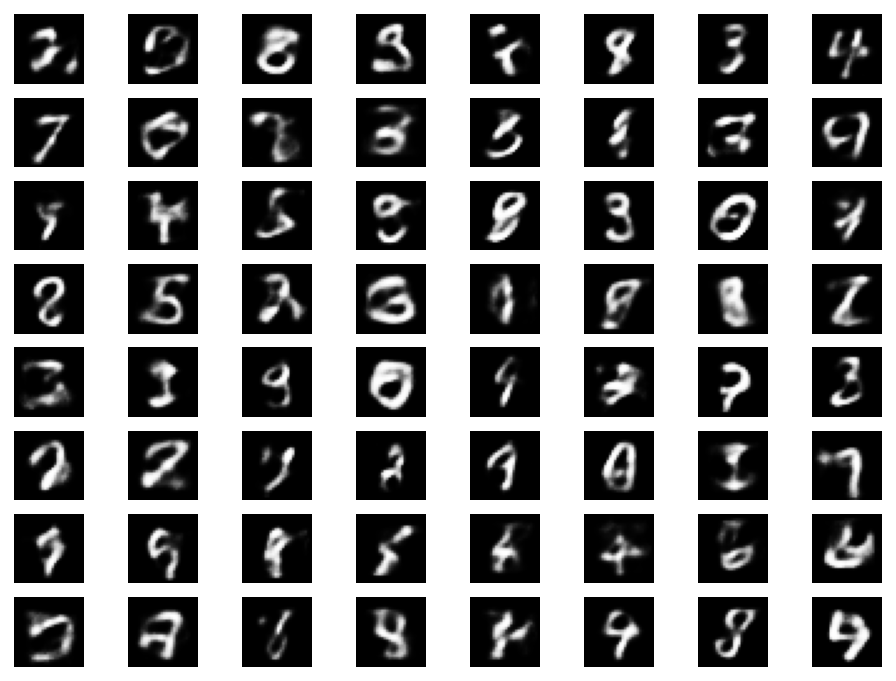

Epoch: 6, Loss: 17.964754104614258, Recon Loss: 13.780526161193848, KL Loss: 4.184227466583252
Epoch: 7, Loss: 15.292366027832031, Recon Loss: 11.690468788146973, KL Loss: 3.6018974781036377
Epoch: 8, Loss: 13.307487487792969, Recon Loss: 10.145368576049805, KL Loss: 3.1621181964874268
Epoch: 9, Loss: 11.775278091430664, Recon Loss: 8.961806297302246, KL Loss: 2.8134710788726807
Epoch: 10, Loss: 10.551462173461914, Recon Loss: 8.017653465270996, KL Loss: 2.5338094234466553


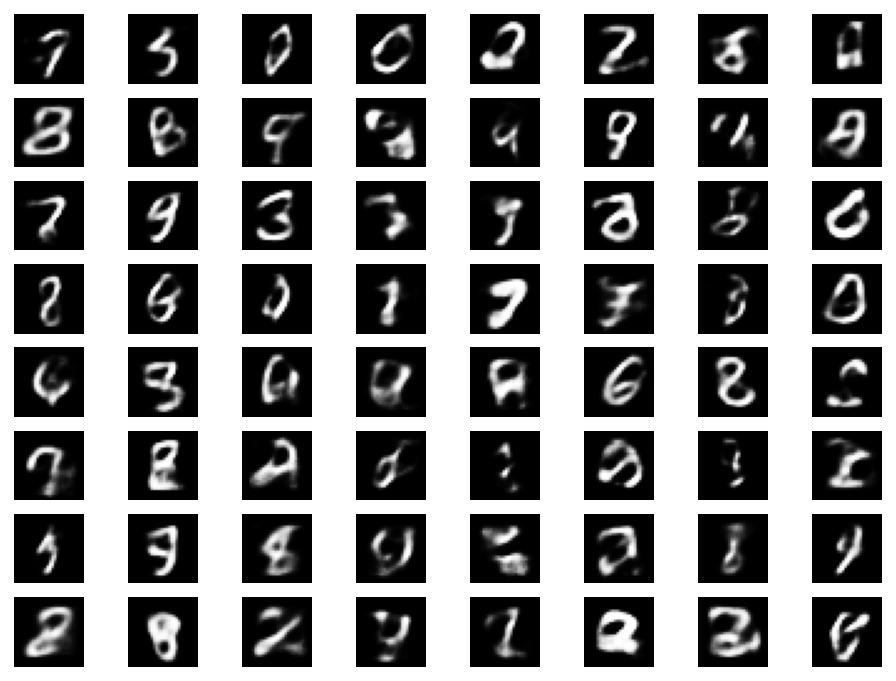

Epoch: 11, Loss: 9.564311981201172, Recon Loss: 7.258394718170166, KL Loss: 2.3059170246124268
Epoch: 12, Loss: 8.744312286376953, Recon Loss: 6.62605619430542, KL Loss: 2.118255853652954
Epoch: 13, Loss: 8.051811218261719, Recon Loss: 6.095515251159668, KL Loss: 1.956296443939209
Epoch: 14, Loss: 7.455794334411621, Recon Loss: 5.6401262283325195, KL Loss: 1.8156685829162598
Epoch: 15, Loss: 6.945572376251221, Recon Loss: 5.248594760894775, KL Loss: 1.696977972984314


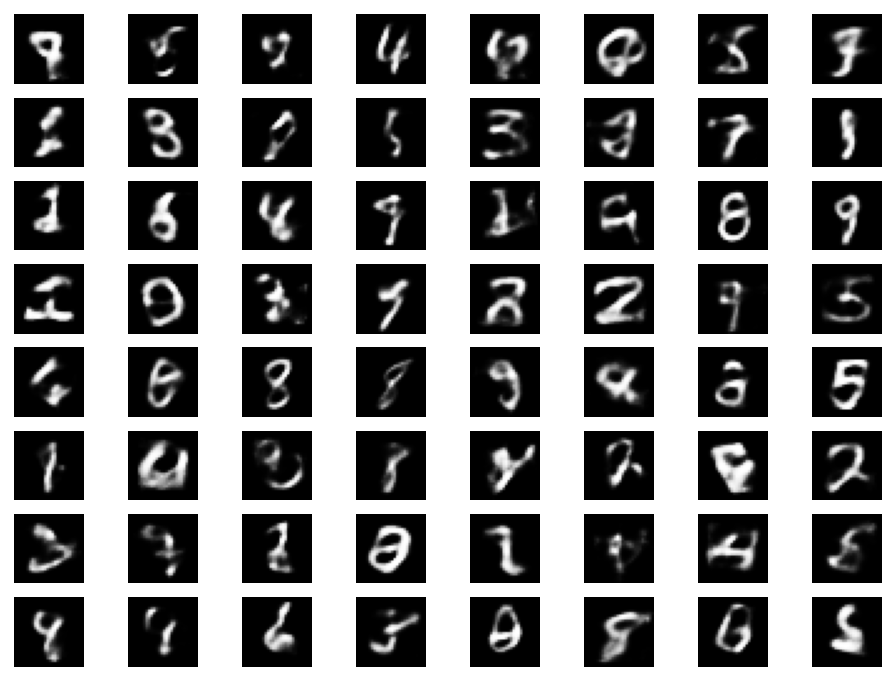

Epoch: 16, Loss: 6.499363422393799, Recon Loss: 4.908079624176025, KL Loss: 1.591284155845642
Epoch: 17, Loss: 6.109477996826172, Recon Loss: 4.609857082366943, KL Loss: 1.499621033668518
Epoch: 18, Loss: 5.761129379272461, Recon Loss: 4.344648838043213, KL Loss: 1.4164807796478271
Epoch: 19, Loss: 5.448906898498535, Recon Loss: 4.104621887207031, KL Loss: 1.3442848920822144
Epoch: 20, Loss: 5.169881820678711, Recon Loss: 3.8930130004882812, KL Loss: 1.2768688201904297


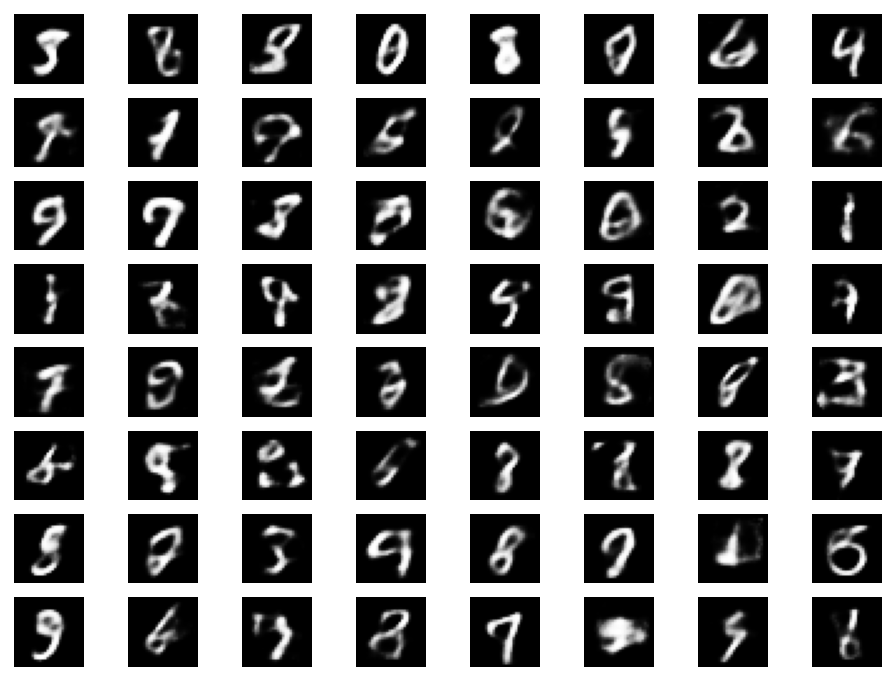

Training Done !


In [6]:
# Training Phase
print_every = 1
plot_every = 5
print("Start training !")
total = 0
# Training loop
for epoch in range(EPOCHS):
    bce_sum = 0
    kl_sum = 0
    for batch_img, _ in train_iter:

        X = batch_img.view(batch_img.size(0), -1).to(device)
        
        x_recon, mu, logvar = model(X)
        
        # Training Discriminator
        loss, bce_loss, kl_loss = criterion(x_recon, X, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += X.size(0)
        bce_sum += bce_loss
        kl_sum += kl_loss
        
    if (((epoch+1)%print_every)==0) or ((epoch+1)==(EPOCHS-1)):
            print(f"Epoch: {epoch+1}, Loss: {(bce_sum+kl_sum)/total}, Recon Loss: {bce_sum/total}, KL Loss: {kl_sum/total}")
    if (((epoch+1)%plot_every)==0) or ((epoch+1)==(EPOCHS)):
        plot_generator()
print("Training Done !")